In [3]:
library(Matrix)
library(tidyverse)
library(ggpointdensity)
library(scico)
library(scales)
library(purrr)
library(DoubletFinder)
library(DropletUtils)
library(ggplot2)
library(patchwork)
library(scDblFinder)
library(SingleCellExperiment)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attachi

In [4]:
outdir <- "/mnt/data1/10XvParse/Analysis_2/"
methods <- c('10x','polyT', 'randO', 'parse')
modified <- c(FALSE, FALSE, FALSE, TRUE)
expected_doublet_rate = c(0.076, 0.003, 0.003, 0.003)

In [5]:
get_mat_dir <- function(type, outdir) {
  # Unpack type values
  method <- type[[1]]
  modified <- type[[2]]

  # Generate Path
  m_string <- ifelse(modified, "_modified", "")
  dir <- paste0(outdir, method, "_out/") |>
         paste0("counts_unfiltered", m_string, "/")
  
  return(dir)
}

read_count_output <- function(dir) {
  dir <- normalizePath(dir, mustWork = TRUE)
  name <- "cells_x_genes"
  m <- readMM(paste0(dir, "/", name, ".mtx")) |>
       Matrix::t() |> 
       as("CsparseMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ".genes.txt")))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m) 
}

In [11]:
get_mats <- function(type, outdir){
  m <- get_mat_dir(type, outdir) |>
       read_count_output()
  return(m)
}

knee_plot <- function(bc_rank, cutoff = NULL) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>%
    distinct() %>%
    dplyr::filter(total > 0)

  ifelse(is.null(cutoff),
    annot <- tibble(
      inflection = metadata(bc_rank)[["inflection"]],
      rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]])),
    annot <- tibble(
      inflection = cutoff,
      rank_cutoff = max(bc_rank$rank[bc_rank$total > cutoff])
    )
  )
                
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

filter_mats <- function(m, bc_rank){
  tot_counts <- Matrix::colSums(m)
  m <- m[, tot_counts > metadata(bc_rank)$inflection]
  m <- m[Matrix::rowSums(m) > 0,]
  return(m)
}

In [12]:
generate_method_df <- function(methods, modified){
    combos <- data.frame(method = methods, modified = modified)
    return(combos)
}

In [13]:
method_df = generate_method_df(methods, modified)
method_df

method,modified
<chr>,<lgl>
10x,FALSE
polyT,FALSE
randO,FALSE
parse,TRUE


In [14]:
mats <- apply(method_df, 1, \(s) get_mats(s, outdir))
bc_ranks <- map(mats, \(m) barcodeRanks(m, lower=10))

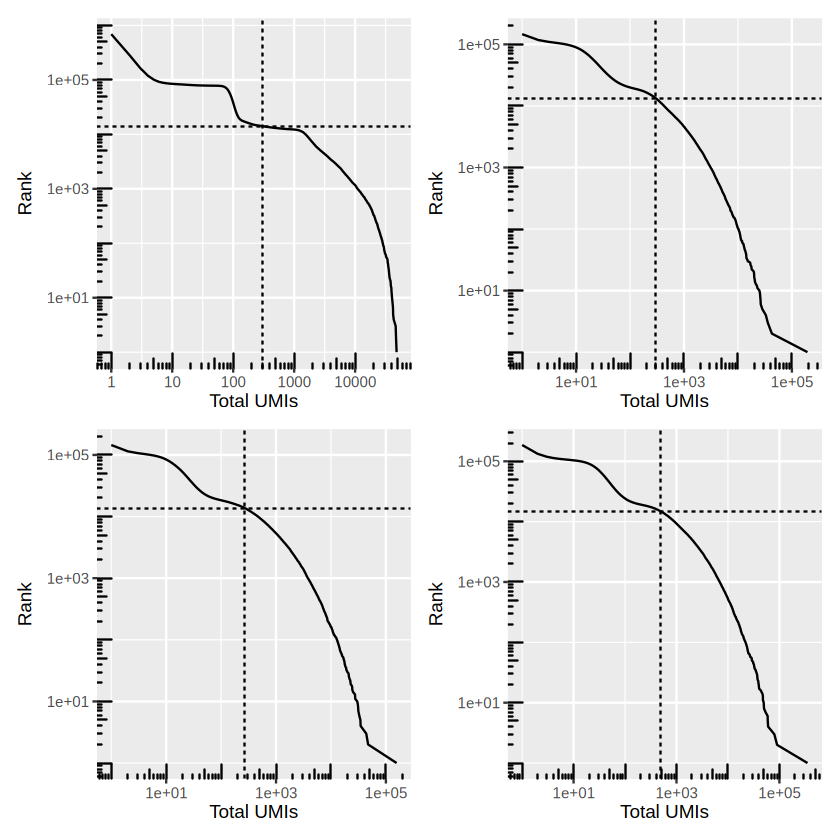

In [ ]:
cutoffs = c(298, 302, 271, 482) # same as used in combo_test.ipynb
plots <- map2(bc_ranks, cutoffs, knee_plot)
wrap_plots(plots, ncol=2)

In [17]:
mats <- map2(mats, bc_ranks, filter_mats)

In [18]:
generate_SCE <- function(m, name){
    sce <- SingleCellExperiment(list(counts=m), mainExpName=name)
    return(sce)
}

In [19]:
sces <- map2(mats, method_df$method, generate_SCE)

In [20]:
sces <- map(sces, scDblFinder)

Warning message in .checkSCE(sce, coerce = is.null(samples)):
“Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out”
Warning message in .f(.x[[i]], ...):
“You are trying to run scDblFinder on a very large number of cells. If these are from different captures, please specify this using the `samples` argument.TRUE”
Creating ~25000 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 12103 cells excluded from training.

Warning message in check.deprecation(deprecated_cv_params, match.call(), ...):
“Passed invalid function arguments: max_depth, eval_metric, tree_method, subsample, nthread, eta. These should be passed as a list to argument 'params'. Conversion from argument to 'params' entry will be done automatically, but this behavior will become an error in a future version.”
Warning message in throw_err_or_depr_msg("Parameter(s) have been removed from this function: ", :
“Parame

In [21]:
get_cell_num <- function(sce){
    cell_num <- length(sce$scDblFinder.class)
    return(cell_num)
}

get_db_num <- function(sce){
    db_num <- sum(sce$scDblFinder.class == 'doublet')
    return(db_num)
}

db_nums <- map(sces, get_db_num)
cell_nums <- map(sces, get_cell_num)

In [23]:
method_df$db_num <- as.numeric(db_nums)
method_df$cell_num <- as.numeric(cell_nums)
method_df$db_percent <- method_df$db_num / method_df$cell_num *100
method_df

method,modified,db_num,cell_num,db_percent
<chr>,<lgl>,<dbl>,<dbl>,<dbl>
10x,FALSE,13952,78422,17.79093
polyT,FALSE,3587,19034,18.84522
randO,FALSE,3031,17854,16.97659
parse,TRUE,30088,101206,29.72946


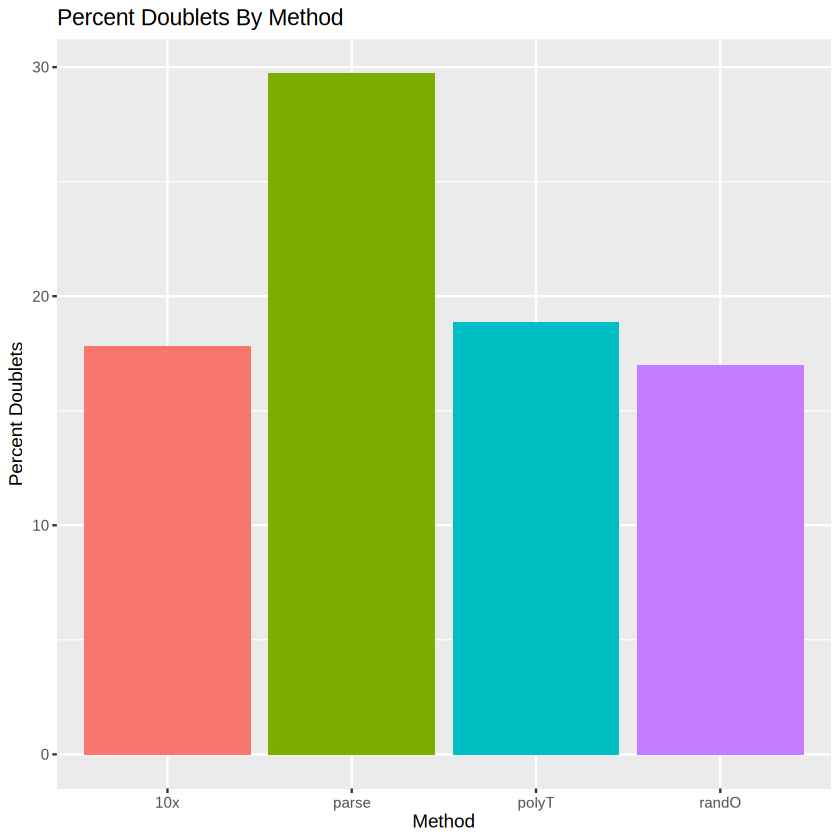

In [24]:
ggplot(method_df, aes(x = method, y = db_percent, fill = method)) + 
    geom_bar(stat = "identity") + 
    labs(
        title = "Percent Doublets By Method",
        x = "Method", y = "Percent Doublets") + 
    theme(legend.position = "none")

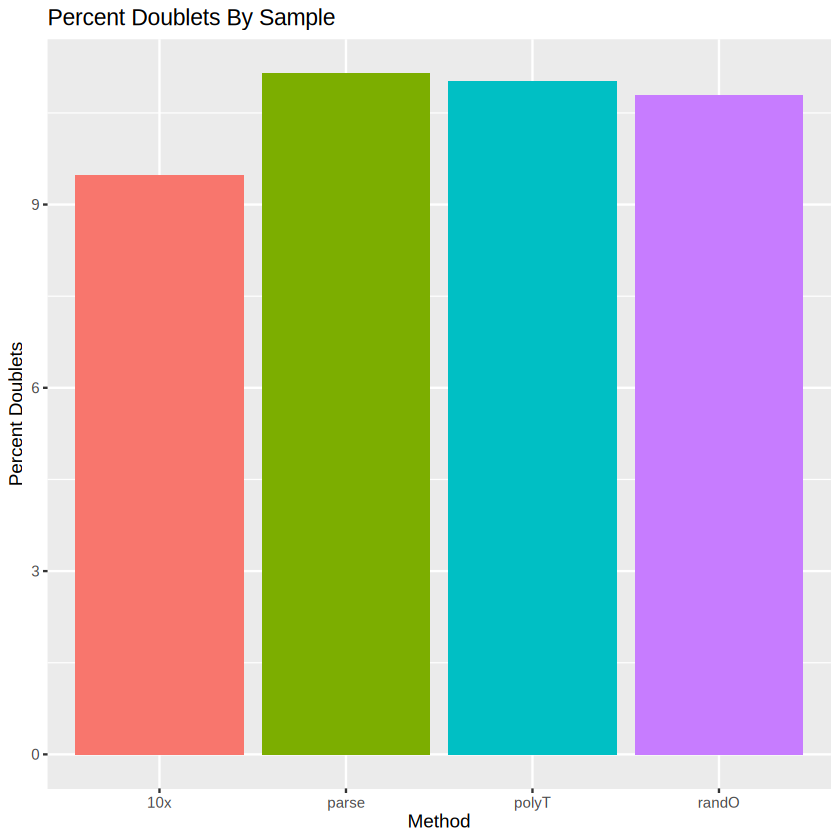

In [73]:
ggplot(combined_df, aes(x = method, y = db_percent, fill = method)) + 
    geom_bar(stat = "identity") + 
    labs(
        title = "Percent Doublets By Sample",
        x = "Method", y = "Percent Doublets") + 
    theme(legend.position = "none")